In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 黑体字体路径
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
def is_column_all_integers_and_less_than_10(column):
    is_all_integers = np.all(np.equal(np.mod(column, 1), 0))  # 检查是否所有值都是整数
    is_all_less_than_10 = np.all(column < 10)  # 检查是否所有值都小于10
    return is_all_integers and is_all_less_than_10


def clean_error(data1):
    # 计算每个特征的均值和标准差,清除异常值
    mean = np.mean(data1, axis=0)
    std = np.std(data1, axis=0)

    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    skip_columns = [is_column_all_integers_and_less_than_10(data1[:, i]) for i in range(data1.shape[1])]
    valid_rows = np.ones(data1.shape[0], dtype=bool)  # 初始化为True
    for i in range(data1.shape[1]):  # 遍历每个特征
        if not skip_columns[i]:  # 仅对不满足条件的列进行检查
            within_bounds = (data1[:, i] >= lower_bound[i]) & (data1[:, i] <= upper_bound[i])
            valid_rows &= within_bounds  # 更新有效行的条

    data1 = data1[valid_rows]
    return data1


def min_max_normalize(data):
    data_min = np.min(data, axis=0)  # 每列的最小值
    data_max = np.max(data, axis=0)  # 每列的最大值
    range_ = data_max - data_min  # 每列的范围
    range_[range_ == 0] = 1  # 将范围设为1，避免除以0
    data_min[range_ == 0] = 0  # 将最小值设为0，使归一化后值为0
    normalized_data = (data - data_min) / range_
    return normalized_data




In [3]:
df1 = pd.read_excel(r"C:\Users\MichaelY\Desktop\黄疸\黄疸汇总.xlsx")  # 类别1的数据
df21 = pd.read_excel(r"C:\Users\MichaelY\Desktop\黄疸\非黄疸汇总.xlsx")  # 类别2的数据
df22 = pd.read_excel(r"C:\Users\MichaelY\Desktop\黄疸\非黄疸汇总2.xlsx")  # 类别2的数据

In [4]:
df1 = df1.apply(pd.to_numeric, errors='coerce')
df21 = df21.apply(pd.to_numeric, errors='coerce')
df22 = df22.apply(pd.to_numeric, errors='coerce')
data1 = df1.to_numpy()
data21 = df21.to_numpy()
data22 = df22.to_numpy()

data1 = data1[~np.isnan(data1).any(axis=1)]
data21 = data21[~np.isnan(data21).any(axis=1)]
data22 = data22[~np.isnan(data22).any(axis=1)]
data2 = np.concatenate([data21, data22])

data1, data2 = clean_error(data1), clean_error(data2)
data1, data2 = min_max_normalize(data1), min_max_normalize(data2)
X = np.concatenate([data1, data2])
Y = np.concatenate([np.zeros(data1.shape[0]), np.ones(data2.shape[0])])
try:
    feature_names = df1.columns.tolist()
except:
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

    # 预测
y_pred = model.predict(X_test)

    # 输出分类结果
print("分类报告：")
print(classification_report(y_test, y_pred))

分类报告：
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97        59
         1.0       0.97      0.99      0.98        75

    accuracy                           0.98       134
   macro avg       0.98      0.98      0.98       134
weighted avg       0.98      0.98      0.98       134



In [5]:
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# 预测概率
y_proba = model.predict_proba(X_test)[:, 1]  # 取正类概率

# ROC曲线 & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# 各项指标
acc = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)  # 灵敏度/召回率
specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出表格
import pandas as pd
metrics = {
    '准确率(Accuracy)': [acc],
    '敏感度(Sensitivity)': [sensitivity],
    '特异度(Specificity)': [specificity],
    '精确率(Precision)': [precision],
    'F1分数(F1 Score)': [f1],
    'AUC': [roc_auc]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


   准确率(Accuracy)  敏感度(Sensitivity)  特异度(Specificity)  精确率(Precision)  \
0       0.977612          0.986667          0.966102        0.973684   

   F1分数(F1 Score)       AUC  
0        0.980132  0.999096  


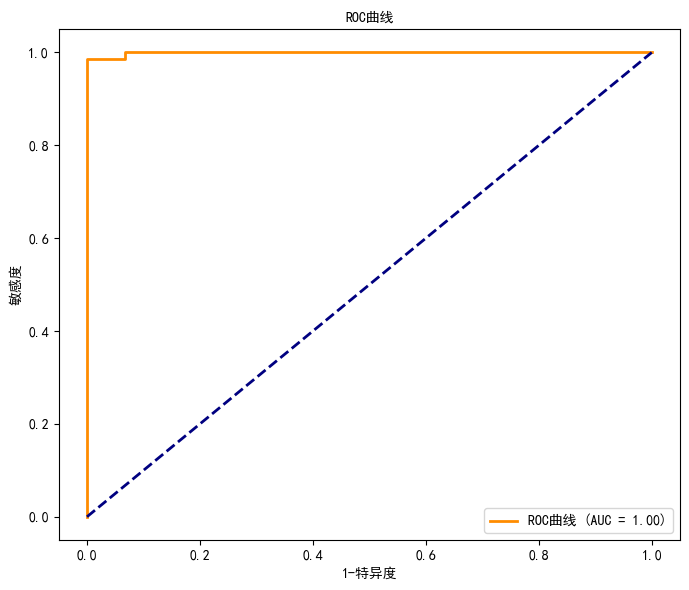

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC曲线 (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('1-特异度', fontproperties=font_prop)
plt.ylabel('敏感度', fontproperties=font_prop)
plt.title('ROC曲线', fontproperties=font_prop)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()


D:\Anaconda\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


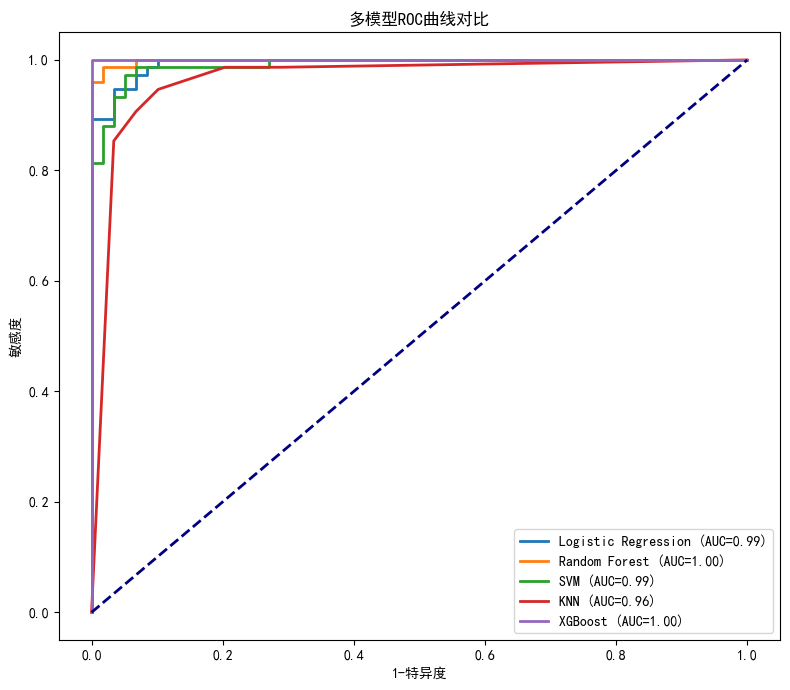

                    模型       准确率       敏感度       特异度       精确率      F1分数  \
0  Logistic Regression  0.947761  0.946667  0.949153  0.959459  0.953020   
1        Random Forest  0.985075  0.986667  0.983051  0.986667  0.986667   
2                  SVM  0.940299  0.933333  0.949153  0.958904  0.945946   
3                  KNN  0.925373  0.946667  0.898305  0.922078  0.934211   
4              XGBoost  0.992537  0.986667  1.000000  1.000000  0.993289   

        AUC  
0  0.993898  
1  0.998644  
2  0.990508  
3  0.964746  
4  1.000000  


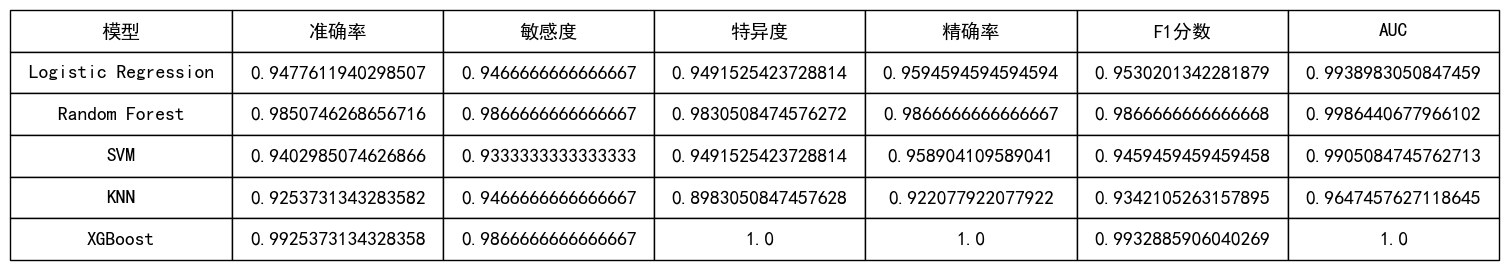

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import dataframe_image as dfi
# 假设你已有 X_train, X_test, y_train, y_test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []
plt.figure(figsize=(8, 7))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # 计算各项指标
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    specificity = TN / (TN + FP)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([name, acc, sensitivity, specificity, precision, f1, roc_auc])
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc:.2f})')

# 画对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('1-特异度')
plt.ylabel('敏感度')
plt.title('多模型ROC曲线对比')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\多模型ROC对比.png", dpi=300, bbox_inches='tight')
plt.show()

# 输出对比表格
columns = ['模型', '准确率', '敏感度', '特异度', '精确率', 'F1分数', 'AUC']
df = pd.DataFrame(results, columns=columns)
print(df)
df.to_excel(r"C:\Users\MichaelY\Desktop\黄疸\多模型主要指标对比.xlsx", index=False)

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width(col=list(range(len(df.columns))))
table.scale(1, 2.5)
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\多模型主要指标对比.png", dpi=300, bbox_inches='tight')
plt.show()

# 用dataframe_image保存美化版
styled_df = df.style.set_properties(**{'font-size': '16pt', 'height': '40px'})
dfi.export(styled_df, r"C:\Users\MichaelY\Desktop\黄疸\多模型主要指标对比_美化版.png", table_conversion="matplotlib")

D:\Anaconda\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


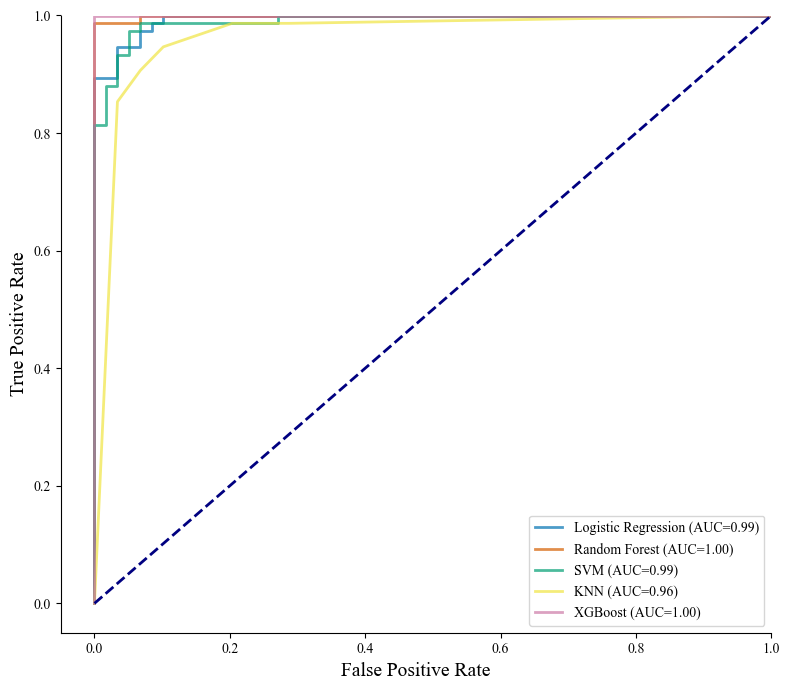

                models  Accuracy  Sensitivity  Specificity  Precision  \
0  Logistic Regression  0.947761     0.946667     0.949153   0.959459   
1        Random Forest  0.985075     0.986667     0.983051   0.986667   
2                  SVM  0.940299     0.933333     0.949153   0.958904   
3                  KNN  0.925373     0.946667     0.898305   0.922078   
4              XGBoost  0.992537     0.986667     1.000000   1.000000   

         F1       AUC  
0  0.953020  0.993898  
1  0.986667  0.999096  
2  0.945946  0.990508  
3  0.934211  0.964746  
4  0.993289  1.000000  


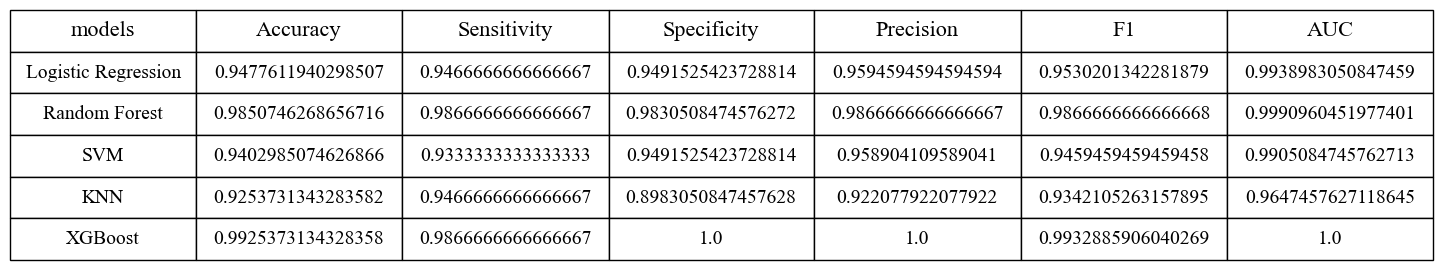

In [8]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, accuracy_score, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import dataframe_image as dfi
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Custom Lancet color palette function
def pal_lancet(palette="lanonc", alpha=1):
    lancet_colors = [
        "#0072B2", "#D55E00", "#009E73", "#F0E442",
        "#CC79A7", "#999999", "#E69F00", "#56B4E9", "#A45C8D"
    ]
    
    if alpha <= 0 or alpha > 1:
        raise ValueError("alpha must be in (0, 1]")
    
    return [(*mcolors.hex2color(c), alpha) for c in lancet_colors]

# Assuming you already have X_train, X_test, y_train, y_test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []
plt.figure(figsize=(8, 7))
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
colors = pal_lancet(alpha=0.7)  # Get colors

for (name, model), color in zip(models.items(), colors):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    specificity = TN / (TN + FP)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([name, acc, sensitivity, specificity, precision, f1, roc_auc])
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, color=color, label=f'{name} (AUC={roc_auc:.2f})')

# Diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate',fontname='Times New Roman' ,fontsize=14)
plt.ylabel('True Positive Rate', fontname = 'Times New Roman',fontsize=14)
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

plt.xlim(-0.05,1)
plt.ylim(-0.05,1)
# Adjust legend properties
plt.legend(loc="lower right", prop={"family": "Times New Roman", "size": 10})  # Set legend font size to 10
plt.tight_layout()
plt.savefig("多模型ROC对比.svg", dpi=300, bbox_inches='tight')
plt.show()

# Output comparison table
columns = ['models', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'AUC']
df = pd.DataFrame(results, columns=columns)
print(df)
df.to_excel("多模型主要指标对比.xlsx", index=False)

# Draw table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)

# Set font properties for the table
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(14)
    cell.set_text_props(fontname='Times New Roman')  # Set regular font
    if i == 0:  # Header row
        cell.set_fontsize(16)

table.auto_set_column_width(col=list(range(len(df.columns))))
table.scale(1, 2.5)
plt.savefig("多模型主要指标对比_table.svg", dpi=300, bbox_inches='tight')
plt.show()

# Save a styled version of the DataFrame using dataframe_image
styled_df = df.style.set_properties(**{'font-size': '16pt', 'height': '40px', 'font-family': 'Times New Roman'})
dfi.export(styled_df, "多模型主要指标对比_美化版.png", table_conversion="matplotlib")

In [ ]:
(4,156,197),(239,39,30)(144,31,123)

In [27]:
def rgb_to_hex(r, g, b, alpha=255):
    """将 RGB 和 Alpha 值转换为 16 进制颜色码"""
    return f"#{r:02X}{g:02X}{b:02X}{alpha:02X}"

# 给定的 RGB 颜色
colors = [
    (4,156,197),(239,39,30),(144,31,123)  
]

# 转换为 16 进制颜色码
hex_colors = [rgb_to_hex(r, g, b) for r, g, b in colors]

# 显示结果
for color, hex_color in zip(colors, hex_colors):
    print(f"RGB: {color} -> Hex: {hex_color}")

RGB: (4, 156, 197) -> Hex: #049CC5FF
RGB: (239, 39, 30) -> Hex: #EF271EFF
RGB: (144, 31, 123) -> Hex: #901F7BFF


                 Model  Accuracy  F1 Score       AUC
0  Logistic Regression  0.947761  0.953020  0.993898
1        Random Forest  0.992537  0.993289  0.999096
2                  SVM  0.940299  0.945946  0.990508
3                  KNN  0.925373  0.934211  0.964746
4              XGBoost  0.992537  0.993289  1.000000


D:\Anaconda\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


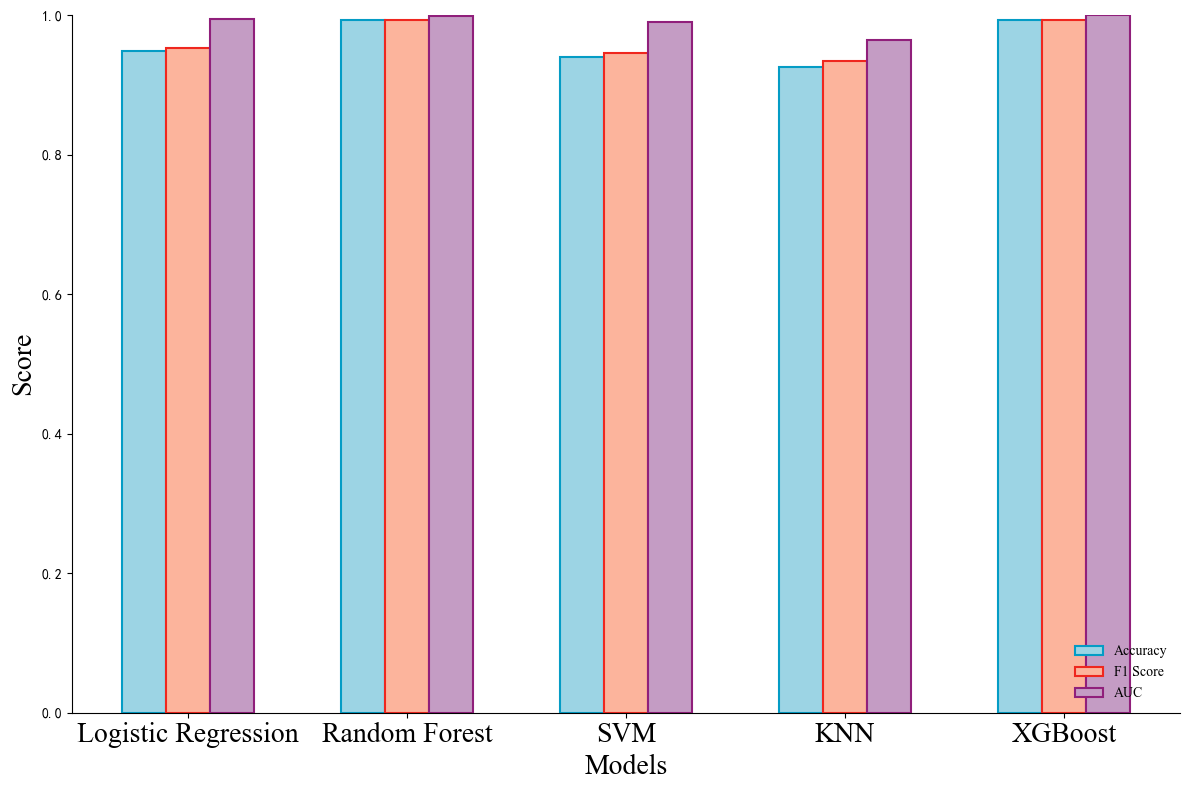

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score,
    recall_score, precision_score, f1_score
)

# Assuming you already have X_train, X_test, y_train, y_test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

# Fit models and calculate metrics
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append only the required metrics
    results.append([name, acc, f1, roc_auc])

# Create DataFrame from results
columns = ['Model', 'Accuracy', 'F1 Score', 'AUC']
df = pd.DataFrame(results, columns=columns)
print(df)

# Save to Excel
df.to_excel(r"C:\Users\MichaelY\Desktop\黄疸\Model_Performance_Comparison.xlsx", index=False)

# Create a figure for the plot
metrics = ['Accuracy', 'F1 Score', 'AUC']  # Metrics to plot
bar_width = 0.2  # Width of the bars
x_indexes = np.arange(len(df['Model']))  # Use 'Model' for x-axis indexes


# Convert RGB values to hexadecimal format
lancet_colors = ['#9CD4E4FF', "#FCB49CFF", "#C49CC4FF"]
side_colors = ['#049CC5FF','#EF271EFF','#901F7BFF']
# Create a figure for the bar plot
plt.figure(figsize=(12,8))

# Plot each metric as bars
for i, metric in enumerate(metrics):
    bars = plt.bar(x_indexes + i * bar_width, df[metric], width=bar_width, 
                   color=lancet_colors[i % len(lancet_colors)], alpha=1, label=metric)
    for bar in bars:
        bar.set_edgecolor(side_colors[i % len(side_colors)])  # Set the border color for the bars
        bar.set_linewidth(1.5)  # Set the border width for the bars

# Set the title and labels
plt.xlabel('Models', fontname='Times New Roman', fontsize=20)
plt.ylabel('Score', fontname='Times New Roman', fontsize=20)
plt.xticks(x_indexes + bar_width, df['Model'], fontname='Times New Roman', fontsize=20)
plt.ylim(0, 1)  # Set limits for score metrics
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add legend
plt.legend(metrics, loc='lower right', prop={'family': 'Times New Roman', 'size': 10}, frameon=False)
plt.tight_layout()

# Save the figure and show it
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\Model_Performance_Comparison_Bar_Chart.svg", dpi=300, bbox_inches='tight')
plt.show()

# Save styled DataFrame as an image
styled_df = df.style.set_properties(**{'font-size': '16pt', 'height': '40px'})
dfi.export(styled_df, r"C:\Users\MichaelY\Desktop\黄疸\Model_Performance_Comparison_Styled.png", table_conversion="matplotlib")

                Models  Mean Accuracy  Accuracy CI Lower  Accuracy CI Upper  \
0  Logistic Regression       0.958881           0.945896           0.972015   
1        Random Forest       0.993468           0.985075           1.000000   
2                  SVM       0.968244           0.953358           0.981343   
3                  KNN       0.911397           0.895522           0.927239   
4              XGBoost       0.993826           0.985075           1.000000   

   Mean AUC  AUC CI Lower  AUC CI Upper  Mean F1 Score  F1 CI Lower  \
0  0.988027      0.984304      0.991334       0.966973     0.956127   
1  0.999803      0.999321      1.000000       0.994743     0.988024   
2  0.994863      0.991332      0.997697       0.974426     0.962064   
3  0.964165      0.952680      0.974798       0.930137     0.917269   
4  0.999807      0.999099      1.000000       0.995028     0.987915   

   F1 CI Upper  Mean Precision  Precision CI Lower  Precision CI Upper  \
0     0.977712        0.

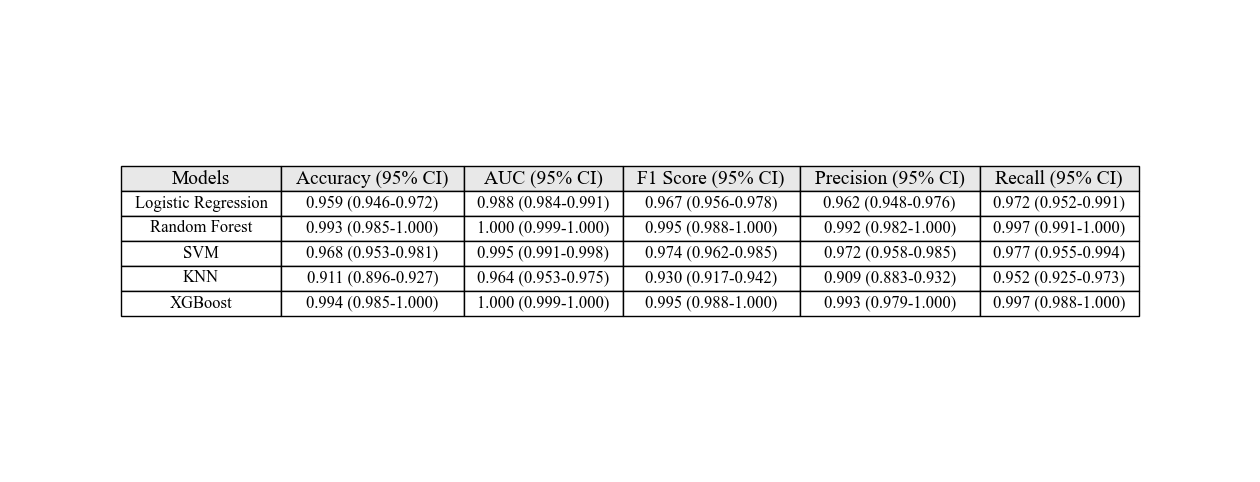

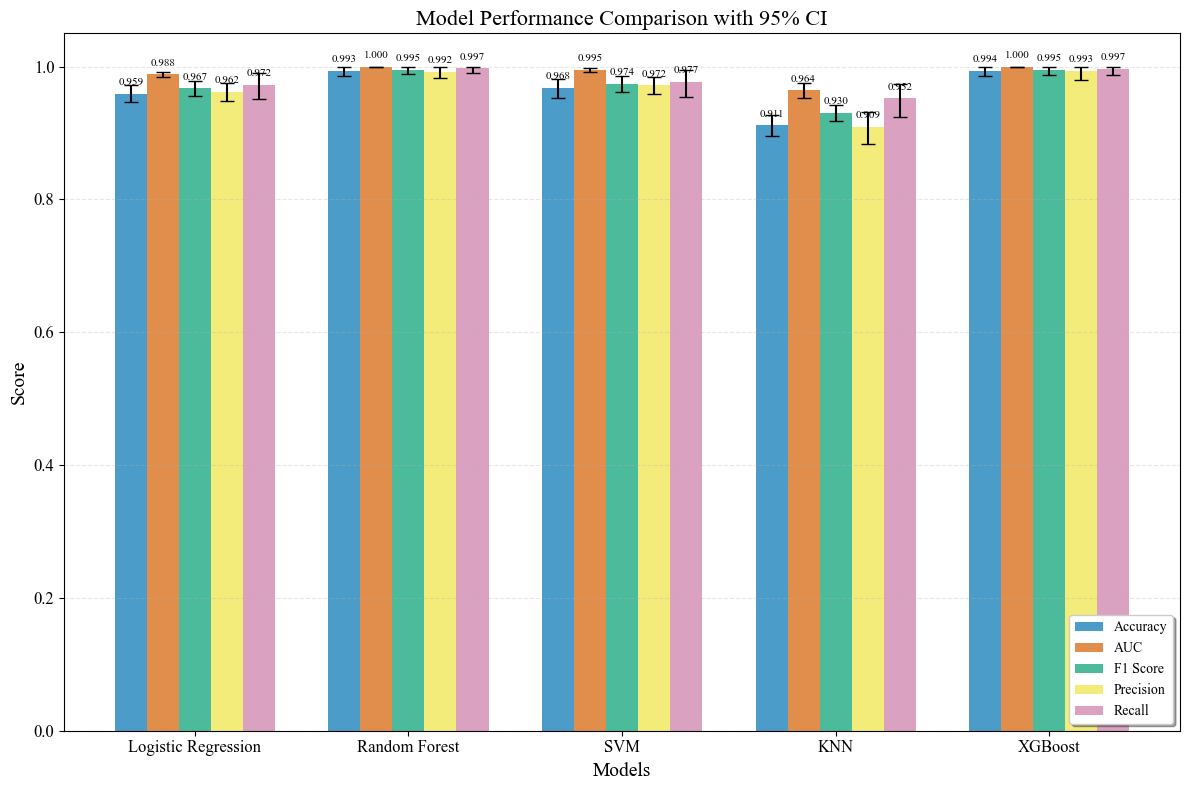


Detailed Model Performance Summary:

Logistic Regression:
  Accuracy: 0.9589 (95% CI: 0.9459 - 0.9720)
  AUC:      0.9880 (95% CI: 0.9843 - 0.9913)
  F1 Score: 0.9670 (95% CI: 0.9561 - 0.9777)
  Precision:0.9619 (95% CI: 0.9475 - 0.9755)
  Recall:   0.9722 (95% CI: 0.9518 - 0.9910)

Random Forest:
  Accuracy: 0.9935 (95% CI: 0.9851 - 1.0000)
  AUC:      0.9998 (95% CI: 0.9993 - 1.0000)
  F1 Score: 0.9947 (95% CI: 0.9880 - 1.0000)
  Precision:0.9924 (95% CI: 0.9822 - 1.0000)
  Recall:   0.9971 (95% CI: 0.9910 - 1.0000)

SVM:
  Accuracy: 0.9682 (95% CI: 0.9534 - 0.9813)
  AUC:      0.9949 (95% CI: 0.9913 - 0.9977)
  F1 Score: 0.9744 (95% CI: 0.9621 - 0.9850)
  Precision:0.9717 (95% CI: 0.9583 - 0.9848)
  Recall:   0.9772 (95% CI: 0.9548 - 0.9941)

KNN:
  Accuracy: 0.9114 (95% CI: 0.8955 - 0.9272)
  AUC:      0.9642 (95% CI: 0.9527 - 0.9748)
  F1 Score: 0.9301 (95% CI: 0.9173 - 0.9419)
  Precision:0.9094 (95% CI: 0.8827 - 0.9320)
  Recall:   0.9521 (95% CI: 0.9247 - 0.9730)

XGBoost:
  A

In [12]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, accuracy_score, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Custom Lancet color palette function
def pal_lancet(palette="lanonc", alpha=1):
    lancet_colors = [
        "#0072B2", "#D55E00", "#009E73", "#F0E442",
        "#CC79A7", "#999999", "#E69F00", "#56B4E9", "#A45C8D"
    ]
    
    if alpha <= 0 or alpha > 1:
        raise ValueError("alpha must be in (0, 1]")
    
    return [(*mcolors.hex2color(c), alpha) for c in lancet_colors]

# Bootstrap function to compute performance metrics
def bootstrap_metrics(model, X, y, n_iterations=1000):
    bootstrapped_scores = []

    for i in range(n_iterations):
        # Generate bootstrap sample
        X_bs, y_bs = resample(X, y)
        model.fit(X_bs, y_bs)
        y_pred = model.predict(X)

        # Calculate metrics for the predictions
        ACC = accuracy_score(y, y_pred)
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])  # Assuming binary classification
        AUC = auc(fpr, tpr)
        F1 = f1_score(y, y_pred)
        Precision = precision_score(y, y_pred)
        Recall = recall_score(y, y_pred)

        # Append scores as a tuple
        bootstrapped_scores.append((ACC, AUC, F1, Precision, Recall))

    # Convert to numpy array for easier manipulation
    bootstrapped_scores = np.array(bootstrapped_scores)

    # Calculate mean and confidence intervals for each metric
    mean_scores = np.mean(bootstrapped_scores, axis=0)
    lower_bounds = np.percentile(bootstrapped_scores, 2.5, axis=0)
    upper_bounds = np.percentile(bootstrapped_scores, 97.5, axis=0)
    
    return mean_scores, lower_bounds, upper_bounds

# Assuming you already have X_train, X_test, y_train, y_test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = []
colors = pal_lancet(alpha=0.7)  # Get colors

# Collect metrics for each model
for (name, model), color in zip(models.items(), colors):
    mean, ci_lower, ci_upper = bootstrap_metrics(model, X_train, y_train)
    
    # Append all metrics to results
    results.append([name, 
                    mean[0], ci_lower[0], ci_upper[0],  # Accuracy
                    mean[1], ci_lower[1], ci_upper[1],  # AUC
                    mean[2], ci_lower[2], ci_upper[2],  # F1 Score
                    mean[3], ci_lower[3], ci_upper[3],  # Precision
                    mean[4], ci_lower[4], ci_upper[4]]) # Recall

# Create DataFrame with proper column structure
columns = ['Models', 
           'Mean Accuracy', 'Accuracy CI Lower', 'Accuracy CI Upper', 
           'Mean AUC', 'AUC CI Lower', 'AUC CI Upper', 
           'Mean F1 Score', 'F1 CI Lower', 'F1 CI Upper', 
           'Mean Precision', 'Precision CI Lower', 'Precision CI Upper', 
           'Mean Recall', 'Recall CI Lower', 'Recall CI Upper']
df = pd.DataFrame(results, columns=columns)
print(df)
df.to_excel("多模型主要指标对比.xlsx", index=False)

# Draw table
fig, ax = plt.subplots(figsize=(16, 6))
ax.axis('off')

# Prepare table data with formatted confidence intervals
table_data = []
for _, row in df.iterrows():
    table_row = [
        row['Models'],
        f"{row['Mean Accuracy']:.3f} ({row['Accuracy CI Lower']:.3f}-{row['Accuracy CI Upper']:.3f})",
        f"{row['Mean AUC']:.3f} ({row['AUC CI Lower']:.3f}-{row['AUC CI Upper']:.3f})",
        f"{row['Mean F1 Score']:.3f} ({row['F1 CI Lower']:.3f}-{row['F1 CI Upper']:.3f})",
        f"{row['Mean Precision']:.3f} ({row['Precision CI Lower']:.3f}-{row['Precision CI Upper']:.3f})",
        f"{row['Mean Recall']:.3f} ({row['Recall CI Lower']:.3f}-{row['Recall CI Upper']:.3f})"
    ]
    table_data.append(table_row)

table_columns = ['Models', 'Accuracy (95% CI)', 'AUC (95% CI)', 'F1 Score (95% CI)', 
                 'Precision (95% CI)', 'Recall (95% CI)']

table = ax.table(cellText=table_data, colLabels=table_columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)

# Set font properties for the table
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(12)
    cell.set_text_props(fontname='Times New Roman')
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_facecolor('#E8E8E8')

table.auto_set_column_width(col=list(range(len(table_columns))))
table.scale(1, 1.5)
plt.savefig("多模型主要指标对比_table.svg", dpi=300, bbox_inches='tight')
plt.show()

# Create bar plot with confidence intervals
# Lancet color palette (converted from RGB)
lancet_colors = ['#0072B2', '#D55E00', '#009E73', '#F0E442', '#CC79A7']

# Metrics to plot
metrics = ['Accuracy', 'AUC', 'F1', 'Precision', 'Recall']
metric_columns = ['Mean Accuracy', 'Mean AUC', 'Mean F1 Score', 'Mean Precision', 'Mean Recall']
metric_labels = ['Accuracy', 'AUC', 'F1 Score', 'Precision', 'Recall']  # For display

bar_width = 0.15
x_indexes = np.arange(len(df['Models']))

# Create figure
plt.figure(figsize=(12, 8))

# Plot each metric
for i, (metric, metric_col, label) in enumerate(zip(metrics, metric_columns, metric_labels)):
    # Get values
    metric_values = df[metric_col].values
    
    # Get confidence intervals - using the actual column names from the DataFrame
    if metric == 'F1':
        ci_lower_col = 'F1 CI Lower'
        ci_upper_col = 'F1 CI Upper'
    else:
        ci_lower_col = f'{metric} CI Lower'
        ci_upper_col = f'{metric} CI Upper'
    
    ci_lower_values = df[ci_lower_col].values
    ci_upper_values = df[ci_upper_col].values
    
    # Calculate error bars
    yerr_lower = metric_values - ci_lower_values
    yerr_upper = ci_upper_values - metric_values
    yerr = [yerr_lower, yerr_upper]
    
    # Plot bars
    plt.bar(x_indexes + i * bar_width, 
            metric_values, 
            width=bar_width, 
            color=lancet_colors[i], 
            alpha=0.7, 
            label=label,  # Use the display label
            yerr=yerr,
            capsize=5,
            error_kw={'linewidth': 1.5})

# Customize plot
plt.title("Model Performance Comparison with 95% CI", fontname='Times New Roman', fontsize=16)
plt.xlabel('Models', fontname='Times New Roman', fontsize=14)
plt.ylabel('Score', fontname='Times New Roman', fontsize=14)
plt.xticks(x_indexes + bar_width * (len(metrics) - 1) / 2, df['Models'], 
           fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
plt.legend(loc='lower right', prop={'family': 'Times New Roman', 'size': 10}, 
           frameon=True, fancybox=True, shadow=True)

# Add value labels on top of bars (optional)
for i, metric_col in enumerate(metric_columns):
    metric_values = df[metric_col].values
    for j, value in enumerate(metric_values):
        plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.tight_layout()

# Save and show
plt.savefig("多模型主要指标对比.svg", dpi=300, bbox_inches='tight')
plt.show()

# Create a separate detailed metrics summary
print("\nDetailed Model Performance Summary:")
print("="*80)
for idx, row in df.iterrows():
    print(f"\n{row['Models']}:")
    print(f"  Accuracy: {row['Mean Accuracy']:.4f} (95% CI: {row['Accuracy CI Lower']:.4f} - {row['Accuracy CI Upper']:.4f})")
    print(f"  AUC:      {row['Mean AUC']:.4f} (95% CI: {row['AUC CI Lower']:.4f} - {row['AUC CI Upper']:.4f})")
    print(f"  F1 Score: {row['Mean F1 Score']:.4f} (95% CI: {row['F1 CI Lower']:.4f} - {row['F1 CI Upper']:.4f})")
    print(f"  Precision:{row['Mean Precision']:.4f} (95% CI: {row['Precision CI Lower']:.4f} - {row['Precision CI Upper']:.4f})")
    print(f"  Recall:   {row['Mean Recall']:.4f} (95% CI: {row['Recall CI Lower']:.4f} - {row['Recall CI Upper']:.4f})")

In [50]:
plt.rc('font', family='serif', serif='Times New Roman') 
def analyze_feature_importance_with_shap(model, X_test, feature_names):
    import shap
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import scipy.io as io
    
    # 创建SHAP解释器
    explainer = shap.TreeExplainer(model)
    
    # 计算SHAP值（使用测试集或训练集的子集）
    # 对于大数据集，可以使用样本来加速计算
    shap_values = explainer.shap_values(X_test)

    # 创建包含特征名称的DataFrame
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    # 处理SHAP值并计算特征重要性
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # 二分类问题 - 使用正类的SHAP值
        shap_importance = np.abs(shap_values[1]).mean(axis=0)
        
        # 可视化SHAP值的摘要图 - 使用正类的SHAP值
        shap.summary_plot(shap_values[1], X_test_df, plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig('./shap_importance_bar.png', dpi=300, bbox_inches='tight')
        plt.figure()
        
        # 可视化SHAP值的蜂群图 - 使用正类的SHAP值
        shap.summary_plot(shap_values[1], X_test_df, show=False)
        plt.tight_layout()
        plt.savefig('./shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
        
        # 保存时也使用正类的SHAP值
        save_shap_values = shap_values[1]
    else:
        # 回归或单类问题
        shap_importance = np.abs(shap_values).mean(axis=0)
        
        # 可视化SHAP值的摘要图
        shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig('./shap_importance_bar.svg', dpi=300, bbox_inches='tight')
        plt.figure()
        
        # 可视化SHAP值的蜂群图
        shap.summary_plot(shap_values, X_test_df, show=False)
        plt.tight_layout()
        plt.savefig('./shap_importance_beeswarm.svg', dpi=300, bbox_inches='tight')
        
        # 保存原始SHAP值
        save_shap_values = shap_values
        
    # 创建特征重要性DataFrame
    feature_importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": shap_importance
    })

    # 按重要性排序
    feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

    print("SHAP特征重要性：")
    print(feature_importance_df)

    # 保存SHAP值和特征重要性
    io.savemat('./shap_importance.mat', {
        'shap_values': save_shap_values,
        'feature_names': feature_names,
        'shap_importance': shap_importance
    })

    # 返回模型和SHAP解释器
    return model, explainer, feature_importance_df


SHAP特征重要性：
                           feature  importance
6                              BMI    2.959353
28         Experienced weight loss    1.654238
53                       Walk 100m    1.105576
52       Climb stairs without rest    1.088298
14            Basal Metabolic Rate    1.028760
1                              Age    0.445791
30        Weight one year ago (kg)    0.305516
12                   Body fat mass    0.263057
0                           Gender    0.184486
35             Current food intake    0.173342
32            Weight one month ago    0.158070
34                 Diet last month    0.081172
8              Waist circumference    0.068252
31           Weight six months ago    0.061746
51           Fatigue in last month    0.049844
11            Skeletal muscle mass    0.045074
10              Waist-to-hip ratio    0.039964
7                       Heart rate    0.038969
5               Height cm accurate    0.038945
50    Physical activity last month    0.036637
33

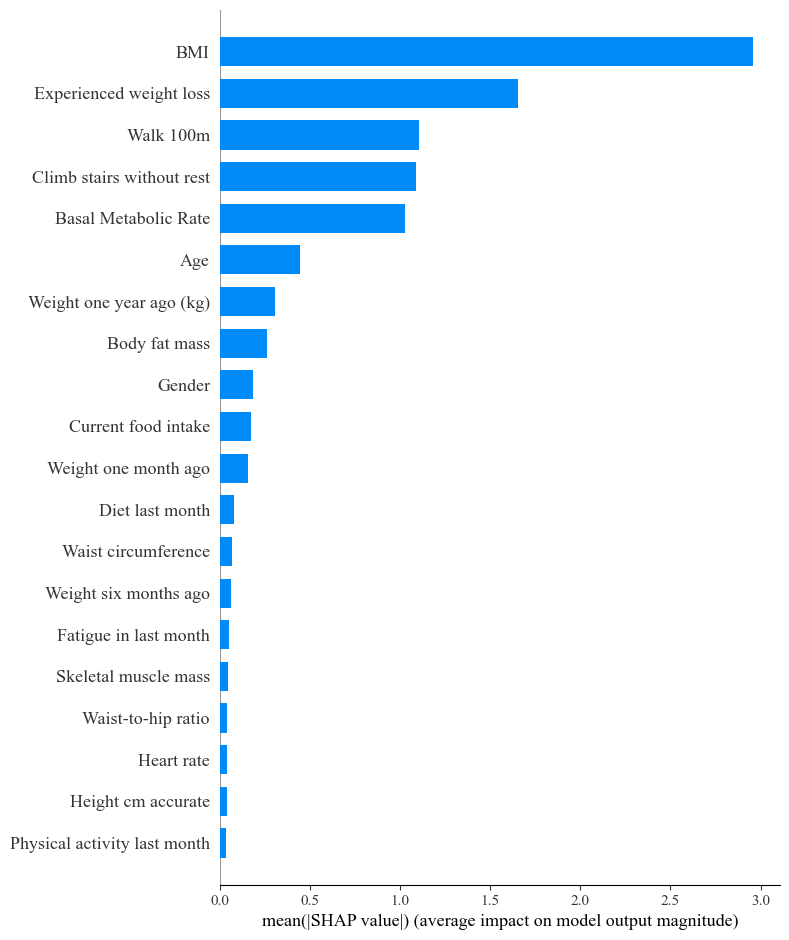

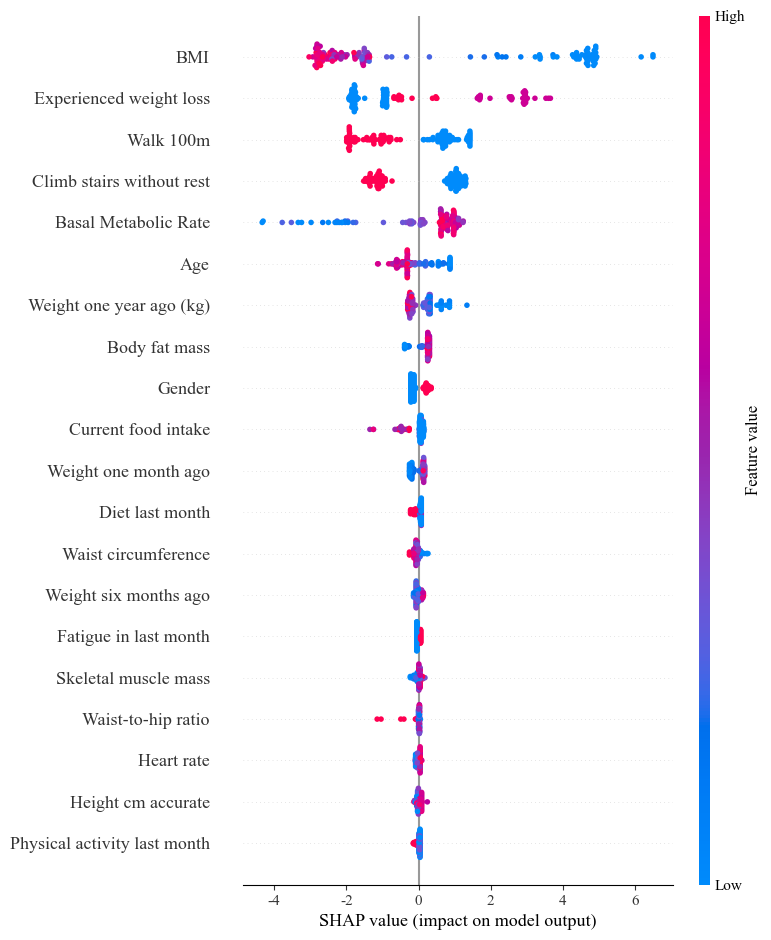

In [51]:
model, explainer, importance_df = analyze_feature_importance_with_shap(model, X_test, feature_names)

In [22]:
df1 = pd.read_excel(r"C:\Users\MichaelY\Desktop\黄疸\黄疸多分类.xlsx") 
df1['25、黄疸类型'].value_counts()

25、黄疸类型
2    198
4     54
3     27
1      1
Name: count, dtype: int64

In [23]:
df1 = df1[df1['25、黄疸类型'] != 1]

In [24]:
df1['25、黄疸类型'].value_counts()

25、黄疸类型
2    198
4     54
3     27
Name: count, dtype: int64

In [51]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import StratifiedKFold

In [52]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
class3_f1_scores = []
df1 = pd.read_excel(r"C:\Users\MichaelY\Desktop\黄疸\黄疸多分类.xlsx") 
original_columns = df1.columns.tolist()
target_column_index = 91
target_column_name = original_columns[target_column_index]
print(f"目标列名(索引{target_column_index}): {target_column_name}")
df1 = df1[df1['25、黄疸类型'] != 1]
df1 = df1.apply(pd.to_numeric, errors='coerce')
data1 = df1.to_numpy()
data1 = data1[~np.isnan(data1).any(axis=1)]
data1 = clean_error(data1)


y, X = data1[:, 91], np.delete(data1,91,1)
feature_name_map = {}
for i in range(X.shape[1]):
    orig_idx = i if i < target_column_index else i + 1
    if orig_idx < len(original_columns):
        feature_name_map[i] = original_columns[orig_idx]
    else:
        feature_name_map[i] = f"未知特征_{i}"

# 打印特征映射信息
print(f"特征数量: {X.shape[1]}")
print(f"特征名称映射示例:")
for i in range(min(5, X.shape[1])):
    print(f"特征_{i} -> {feature_name_map[i]}")
X = min_max_normalize(X)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== 第 {fold+1} 折 ===")
    
    # 分割数据
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 查看当前折叠的类别分布
    print(f"训练集类别分布: {Counter(y_train)}")
    print(f"测试集类别分布: {Counter(y_test)}")
    
    # 应用SMOTE过采样
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"重采样后训练集分布: {Counter(y_train_resampled)}")
    
    # 训练模型
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # 使用类权重进一步平衡
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    # 在测试集上评估
    y_pred = model.predict(X_test)
    
    # 生成分类报告
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    
    # 保存结果
    fold_results.append(report)
    
    # 特别关注类别3的F1分数
    if '3.0' in report:
        class3_f1 = report['3.0']['f1-score']
        class3_f1_scores.append(class3_f1)
        print(f"类别3.0的F1分数: {class3_f1:.4f}")
    else:
        print("测试集中没有类别3.0的样本")

# 计算平均性能指标
avg_accuracy = np.mean([r['accuracy'] for r in fold_results])
avg_macro_f1 = np.mean([r['macro avg']['f1-score'] for r in fold_results])
avg_weighted_f1 = np.mean([r['weighted avg']['f1-score'] for r in fold_results])

print("\n=== 交叉验证平均性能 ===")
print(f"平均准确率: {avg_accuracy:.4f}")
print(f"平均宏F1分数: {avg_macro_f1:.4f}")
print(f"平均加权F1分数: {avg_weighted_f1:.4f}")

if class3_f1_scores:
    avg_class3_f1 = np.mean(class3_f1_scores)
    print(f"类别3.0的平均F1分数: {avg_class3_f1:.4f}")
else:
    print("没有折叠包含类别3.0的测试样本")

目标列名(索引91): 25、黄疸类型
特征数量: 110
特征名称映射示例:
特征_0 -> 您的性别
特征_1 -> 您的年龄是多少岁？
特征_2 -> 您的婚姻状况
特征_3 -> 您的民族是
特征_4 -> 文化程度

=== 第 1 折 ===
训练集类别分布: Counter({2.0: 123, 4.0: 35, 3.0: 14})
测试集类别分布: Counter({2.0: 31, 4.0: 8, 3.0: 4})
重采样后训练集分布: Counter({3.0: 123, 2.0: 123, 4.0: 123})


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

         2.0       0.85      0.90      0.88        31
         3.0       0.00      0.00      0.00         4
         4.0       0.70      0.88      0.78         8

    accuracy                           0.81        43
   macro avg       0.52      0.59      0.55        43
weighted avg       0.74      0.81      0.78        43

类别3.0的F1分数: 0.0000

=== 第 2 折 ===
训练集类别分布: Counter({2.0: 123, 4.0: 35, 3.0: 14})
测试集类别分布: Counter({2.0: 31, 4.0: 8, 3.0: 4})
重采样后训练集分布: Counter({3.0: 123, 2.0: 123, 4.0: 123})


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

         2.0       0.83      0.97      0.90        31
         3.0       0.00      0.00      0.00         4
         4.0       0.86      0.75      0.80         8

    accuracy                           0.84        43
   macro avg       0.56      0.57      0.57        43
weighted avg       0.76      0.84      0.79        43

类别3.0的F1分数: 0.0000

=== 第 3 折 ===
训练集类别分布: Counter({2.0: 124, 4.0: 34, 3.0: 14})
测试集类别分布: Counter({2.0: 30, 4.0: 9, 3.0: 4})
重采样后训练集分布: Counter({3.0: 124, 2.0: 124, 4.0: 124})


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

         2.0       0.91      1.00      0.95        30
         3.0       0.00      0.00      0.00         4
         4.0       0.90      1.00      0.95         9

    accuracy                           0.91        43
   macro avg       0.60      0.67      0.63        43
weighted avg       0.82      0.91      0.86        43

类别3.0的F1分数: 0.0000

=== 第 4 折 ===
训练集类别分布: Counter({2.0: 123, 4.0: 34, 3.0: 15})
测试集类别分布: Counter({2.0: 31, 4.0: 9, 3.0: 3})
重采样后训练集分布: Counter({3.0: 123, 2.0: 123, 4.0: 123})


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

         2.0       0.86      0.97      0.91        31
         3.0       0.00      0.00      0.00         3
         4.0       0.88      0.78      0.82         9

    accuracy                           0.86        43
   macro avg       0.58      0.58      0.58        43
weighted avg       0.80      0.86      0.83        43

类别3.0的F1分数: 0.0000

=== 第 5 折 ===
训练集类别分布: Counter({2.0: 123, 4.0: 34, 3.0: 15})
测试集类别分布: Counter({2.0: 31, 4.0: 9, 3.0: 3})
重采样后训练集分布: Counter({3.0: 123, 2.0: 123, 4.0: 123})
              precision    recall  f1-score   support

         2.0       0.93      0.87      0.90        31
         3.0       0.50      0.33      0.40         3
         4.0       0.75      1.00      0.86         9

    accuracy                           0.86        43
   macro avg       0.73      0.73      0.72        43
weighted avg       0.86      0.86      0.86        43

类别3.0的F1分数: 0.4000

=== 交叉验证平均性能 ===
平均准确率: 0.8558
平均宏F1分数: 0.

In [53]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[27  1  3]
 [ 2  1  0]
 [ 0  0  9]]


In [54]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
unique_classes = np.unique(y)
print(f"唯一类别: {unique_classes}")

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('混淆矩阵')
plt.tight_layout()
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.close()

# 计算归一化的混淆矩阵（百分比形式）
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized * 100, 2)  # 转换为百分比并保留两位小数

# 可视化归一化混淆矩阵
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('归一化混淆矩阵 (%)')
plt.tight_layout()
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\confusion_matrix_normalized.png", dpi=300, bbox_inches='tight')
plt.close()

唯一类别: [2. 3. 4.]


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 计算SHAP特征重要性
if isinstance(shap_values, list):
    # 多分类情况
    mean_abs_shap = np.zeros(X_test.shape[1])
    for i in range(len(shap_values)):
        mean_abs_shap += np.abs(shap_values[i]).mean(0)
    mean_abs_shap /= len(shap_values)
else:
    # 二分类情况
    mean_abs_shap = np.abs(shap_values).mean(0)

# 获取特征重要性排序
shap_importance_indices = np.argsort(mean_abs_shap)[::-1]

# 打印SHAP特征重要性和原始列名
print("\nSHAP特征重要性排名(前20):")
for i, idx in enumerate(shap_importance_indices[:20]):
    print(f"{i+1}. {feature_name_map[idx]} (重要性: {mean_abs_shap[idx]:.4f})")

# 获取模型的特征重要性
model_importances = model.feature_importances_
model_importance_indices = np.argsort(model_importances)[::-1]

# 打印模型特征重要性和原始列名
print("\n模型特征重要性排名(前20):")
for i, idx in enumerate(model_importance_indices[:20]):
    print(f"{i+1}. {feature_name_map[idx]} (重要性: {model_importances[idx]:.4f})")

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({
    '特征名称': [feature_name_map[i] for i in range(X.shape[1])],
    'SHAP重要性': mean_abs_shap,
    'SHAP排名': [list(shap_importance_indices).index(i) + 1 for i in range(X.shape[1])],
    '模型重要性': model_importances,
    '模型排名': [list(model_importance_indices).index(i) + 1 for i in range(X.shape[1])]
})

# 按SHAP重要性排序
importance_df = importance_df.sort_values('SHAP重要性', ascending=False)

# 保存到Excel
importance_df.to_excel(r"C:\Users\MichaelY\Desktop\黄疸\特征重要性分析.xlsx", index=False)
print("\n已保存特征重要性分析到 '特征重要性分析.xlsx'")

# 创建可视化图表
print("\n创建SHAP可视化图表...")

# 1. SHAP摘要图
plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values, 
    X_test,
    feature_names=[feature_name_map[i] for i in range(X.shape[1])],
    show=False,
    max_display=20
)
plt.title('SHAP特征重要性摘要图', fontsize=16)
plt.tight_layout()
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()
print("已保存SHAP摘要图")

# 2. SHAP条形图
plt.figure(figsize=(14, 10))
if isinstance(shap_values, list):
    shap.summary_plot(
        shap_values[0], 
        X_test,
        feature_names=[feature_name_map[i] for i in range(X.shape[1])],
        plot_type="bar",
        show=False,
        max_display=20
    )
else:
    shap.summary_plot(
        shap_values, 
        X_test,
        feature_names=[feature_name_map[i] for i in range(X.shape[1])],
        plot_type="bar",
        show=False,
        max_display=20
    )
plt.title('SHAP特征重要性条形图', fontsize=16)
plt.tight_layout()
plt.savefig(r"C:\Users\MichaelY\Desktop\黄疸\shap_bar_plot.png", dpi=300, bbox_inches='tight')
plt.close()
print("已保存SHAP条形图")

# 3. 为前10个最重要的特征创建依赖图
print("\n为前10个最重要特征创建依赖图...")
top_features = shap_importance_indices[:10]
for i, feature_idx in enumerate(top_features):
    plt.figure(figsize=(10, 7))
    feature_name = feature_name_map[feature_idx]
    
    # 处理特征名称，确保文件名有效
    safe_feature_name = "".join(c if c.isalnum() or c in [' ', '_', '-'] else '_' for c in feature_name)
    
    if isinstance(shap_values, list):
        # 多分类情况
        shap.dependence_plot(
            feature_idx, 
            shap_values[0], 
            X_test,
            feature_names=[feature_name_map[j] for j in range(X.shape[1])],
            show=False
        )
    else:
        # 二分类情况
        shap.dependence_plot(
            feature_idx, 
            shap_values, 
            X_test,
            feature_names=[feature_name_map[j] for j in range(X.shape[1])],
            show=False
        )
    
    plt.title(f'特征依赖图: {feature_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"C:\\Users\\MichaelY\\Desktop\\黄疸\\依赖图_{i+1}_{safe_feature_name}.png", dpi=300, bbox_inches='tight')
    plt.close()

print("已完成所有分析！结果保存在指定目录中。")


SHAP特征重要性排名(前20):
1. 26、总胆红素值（umol/L） (重要性: 0.0510)
2. 28、直接胆红素值（umol/L） (重要性: 0.0493)
3. 27、间接胆红素值（umol/L） (重要性: 0.0380)
4. 29、尿胆红素 (重要性: 0.0318)
5. 42、白蛋白（g/L） (重要性: 0.0274)
6. 35、PT凝血酶原时间（s） (重要性: 0.0183)
7. 7、心率 (重要性: 0.0158)
8. 15、(无合并症) (重要性: 0.0147)
9. 36、INR 国际标准化比值 (重要性: 0.0131)
10. 43、球蛋白（g/L） (重要性: 0.0125)
11. 44、红细胞数目（10^12/L） (重要性: 0.0112)
12. 32、AST门冬氨酸氨基转移酶（IU/L） (重要性: 0.0110)
13. 变得容易烦恼或急躁 (重要性: 0.0104)
14. 疲乏调查：
下面图片代表您疲乏的程度。“0”代表“没有疲乏”，“10”代表您能想象的“最严重的疲乏”。从0到10“疲乏”的程度逐渐加深。请圈出最能反映您最近一周“疲乏”程度的数字。—疲乏程度 (重要性: 0.0089)
15. 41、总蛋白（g/L） (重要性: 0.0088)
16. 34、ALP碱性磷酸酶（IU/L） (重要性: 0.0087)
17. 14、NRS2002评分 (重要性: 0.0084)
18. 14(无食欲，不想吃饭) (重要性: 0.0082)
19. 您是否在过去4周内大部分时间或所有时间感到疲乏 (重要性: 0.0069)
20. 13、基础代谢量 (重要性: 0.0067)

模型特征重要性排名(前20):
1. 28、直接胆红素值（umol/L） (重要性: 0.0894)
2. 26、总胆红素值（umol/L） (重要性: 0.0842)
3. 27、间接胆红素值（umol/L） (重要性: 0.0612)
4. 29、尿胆红素 (重要性: 0.0496)
5. 42、白蛋白（g/L） (重要性: 0.0398)
6. 35、PT凝血酶原时间（s） (重要性: 0.0359)
7. 43、球蛋白（g/L） (重要性: 0.0290)
8. 36、INR 国际标准化比值 (重要性: 0.026

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


已保存SHAP摘要图


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


已保存SHAP条形图

为前10个最重要特征创建依赖图...
已完成所有分析！结果保存在指定目录中。


<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>